# We're going to try fitting a full asymptotic relation to some simulated data

We'll do Gaussian noise cos it makes my life easier

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import theano.tensor as tt

import lightkurve as lk
from astropy.units import cds
from astropy import units as u
import seaborn as sns
import mystyle as ms

import corner
import pystan
import pandas as pd
import pickle
import glob
from astropy.io import ascii
import os

from utils import gaussian

import pymc3 as pm
import arviz

## Build the model

In [12]:
class model():
    def __init__(self, f, n0_, n1_, n2_):
        self.f = f
        self.n0 = n0_
        self.n1 = n1_
        self.n2 = n2_
        self.npts = len(f)
        self.M = [len(n0_), len(n1_), len(n2_)]
        
    def epsilon(self, i, theano=True):
        eps = tt.zeros((3,3))
        eps0 = tt.set_subtensor(eps[0][0], 1.)
        eps1 = tt.set_subtensor(eps[1][0], tt.cos(i)**2)
        eps1 = tt.set_subtensor(eps1[1], 0.5 * tt.sin(i)**2)
        eps2 = tt.set_subtensor(eps[2][0], 0.25 * (3. * tt.cos(i)**2 - 1.)**2)
        eps2 = tt.set_subtensor(eps2[1], (3./8.)*tt.sin(2*i)**2)
        eps2 = tt.set_subtensor(eps2[2], (3./8.) * tt.sin(i)**4)

        eps = tt.set_subtensor(eps[0], eps0)
        eps = tt.set_subtensor(eps[1], eps1)
        eps = tt.set_subtensor(eps[2], eps2)
        
        if not theano:
            return eps.eval()
        return eps
            

    def lor(self, freq, h, w):
        return h / (1.0 + 4.0/w**2*(self.f - freq)**2)
    
    def mode(self, l, freqs, hs, ws, eps, split=0):
        for idx in range(self.M[l]):
            for m in range(-l, l+1, 1):
                self.modes += self.lor(freqs[idx] + (m*split), 
                                     hs[idx] * eps[l,abs(m)], 
                                     ws[idx])
  
    def model(self, p, theano=True):
        f0, f1, f2, g0, g1, g2, h0, h1, h2, split, i, b = p
               
        # Calculate the modes
        eps = self.epsilon(i, theano)        
        self.modes = np.zeros(self.npts)
        self.mode(0, f0, h0, g0, eps)
        self.mode(1, f1, h1, g1, eps, split)
        self.mode(2, f2, h2, g2, eps, split)
               
        #Create the model
        self.mod = self.modes + b
        return self.mod

    def asymptotic(self, n, numax, deltanu, alpha, epsilon):       
        nmax = (numax / deltanu) - epsilon
        over = (n + epsilon + ((alpha/2)*(nmax - n)**2))
        return over * deltanu
    
    def f0(self, p):
        numax, deltanu, alpha, epsilon, d01, d02 = p
        
        return self.asymptotic(self.n0, numax, deltanu, alpha, epsilon)
    
    def f1(self, p):
        numax, deltanu, alpha, epsilon, d01, d02 = p
        
        f0 = self.asymptotic(self.n1, numax, deltanu, alpha, epsilon)
        return f0 + d01
    
    def f2(self, p):
        numax, deltanu, alpha, epsilon, d01, d02 = p
        
        f0 = self.asymptotic(self.n2+1, numax, deltanu, alpha, epsilon)
        return f0 - d02

In [13]:
nmodes = 2
nbase = 18
n0_ = np.arange(nmodes)+nbase
n1_ = np.copy(n0_)
n2_ = np.copy(n0_) - 1.
fs = .05
nyq = (0.5 * (1./58.6) * u.hertz).to(u.microhertz).value
ff = np.arange(fs, nyq, fs)

In [21]:
deltanu_  =  60.
numax_= 1150.
alpha_ = 0.
epsilon_ = 0.
d01_ = deltanu_/2.
d02_ = 6.

In [22]:
mod = model(ff, n0_, n1_, n2_)

In [23]:
init_f = [numax_, deltanu_, alpha_, epsilon_, d01_, d02_]
f0_ = mod.f0(init_f)
f1_ = mod.f1(init_f)
f2_ = mod.f2(init_f)

In [24]:
lo = f2_.min() - .25*deltanu_
hi = f1_.max() + .25*deltanu_

sel = (ff > lo) & (ff < hi)
f = ff[sel]

And now lets reset the model for the new frequency range...

In [25]:
mod = model(f, n0_, n1_, n2_)

In [26]:
init_m =[f0_,                         # l0 modes
           f1_,                         # l1 modes
           f2_,                         # l2 modes
           np.ones(len(f0_)) * 2.0,     # l0 widths
           np.ones(len(f1_)) * 2.0,     # l1 widths
           np.ones(len(f2_)) * 2.0,     # l2 widths
           np.sqrt(gaussian(f0_, 0, numax_, 1000.) * 2.0 * np.pi / 2.0) ,# l0 heights
           np.sqrt(gaussian(f1_, 1, numax_, 1000.) * 2.0 * np.pi / 2.0) ,# l1 heights
           np.sqrt(gaussian(f2_, 2, numax_, 1000.) * 2.0 * np.pi / 2.0) ,# l2 heights
           1.,       # splitting
           np.pi/4.,                    # inclination angle
           1.                           # background parameters
        ]
p = mod.model(init_m, theano=False)*np.random.chisquare(2., size=len(f))/2

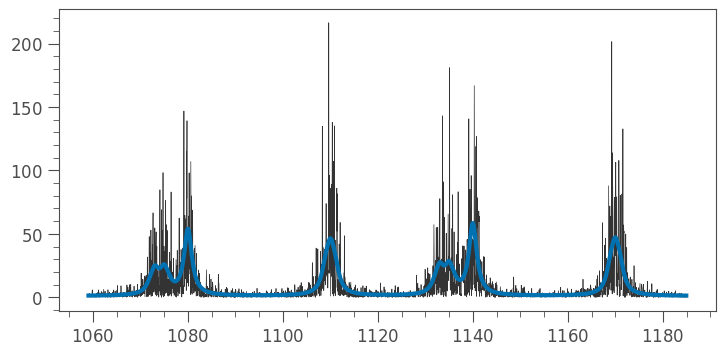

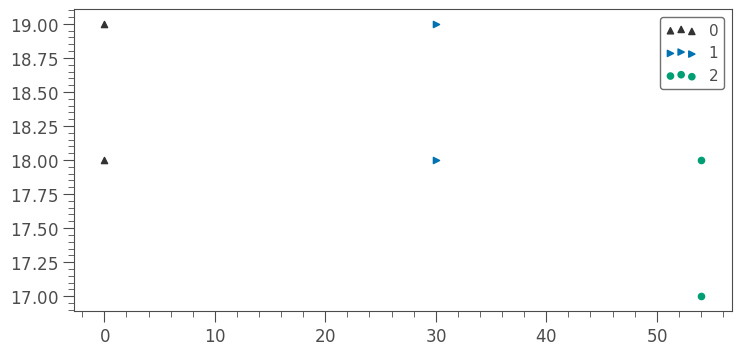

In [27]:
with plt.style.context(ms.ms):
    plt.plot(f, p)
    plt.plot(f, mod.model(init_m, theano=False), lw=3)
    plt.show()
    
    fig, ax = plt.subplots()
    ax.scatter(f0_%deltanu_, n0_, marker='^',label='0', s=20)
    ax.scatter(f1_%deltanu_, n1_, marker='>',label='1', s=20)
    ax.scatter(f2_%deltanu_, n2_, marker='o',label='2', s=20)

    ax.legend()
    plt.show()    

## First lets fit the mode frequencies...

In [33]:
pm_model = pm.Model()

BNormal = pm.Bound(pm.Normal, lower=0.)

with pm_model:   
    numax   = BNormal('numax',   mu=numax_,   sigma=100.,  testval=numax_)
    deltanu = BNormal('deltanu', mu=deltanu_, sigma=.1,  testval=deltanu_)
#     alpha   = BNormal('alpha',   mu=alpha_,   sigma=0.001,  testval=alpha_)
#     epsilon = BNormal('epsilon', mu=epsilon_, sigma=0.01,   testval=epsilon_)
    d01     = BNormal('d01',     mu=d01_,     sigma=5., testval=d01_)
    d02     = BNormal('d02',     mu=d02_,     sigma=1.,  testval=d02_)
    
    f0 = pm.Deterministic('f0', mod.f0([numax, deltanu, 0., 0., d01, d02]))
    f1 = pm.Deterministic('f1', mod.f1([numax, deltanu, 0., 0., d01, d02]))
    f2 = pm.Deterministic('f2', mod.f2([numax, deltanu, 0., 0., d01, d02]))
    
    like0 = pm.Normal('like0', mu=f0, sigma=1., observed=f0_)
    like1 = pm.Normal('lik10', mu=f1, sigma=1., observed=f1_)
    like2 = pm.Normal('lik20', mu=f2, sigma=1., observed=f2_)    
        
    trace = pm.sample(chains=4)

INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [d02, d01, deltanu, numax]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:10<00:00, 389.07draws/s] 


In [34]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
numax,1151.119482,103.809352,2.741793,942.750547,1353.005808,1488.886172,0.999698
deltanu,59.998724,0.031449,0.000895,59.939509,60.061780,1056.720078,0.999238
d01,30.046251,0.893259,0.023488,28.187893,31.701015,1155.788456,0.999552
d02,5.973832,0.714068,0.021477,4.547117,7.403524,1124.195219,1.001374
f0__0,1079.977029,0.566087,0.016105,1078.911164,1081.112041,1056.720078,0.999238
f0__1,1139.975753,0.597536,0.017000,1138.850673,1141.173821,1056.720078,0.999238
f1__0,1110.023280,0.693714,0.013171,1108.545642,1111.284207,2156.535318,0.999691
f1__1,1170.022003,0.694578,0.012948,1168.604913,1171.345417,2237.951297,0.999686
f2__0,1074.003197,0.598522,0.013360,1072.982440,1075.303143,2218.690972,1.001214
f2__1,1134.001921,0.607120,0.013341,1132.948807,1135.294077,2310.670538,1.001100


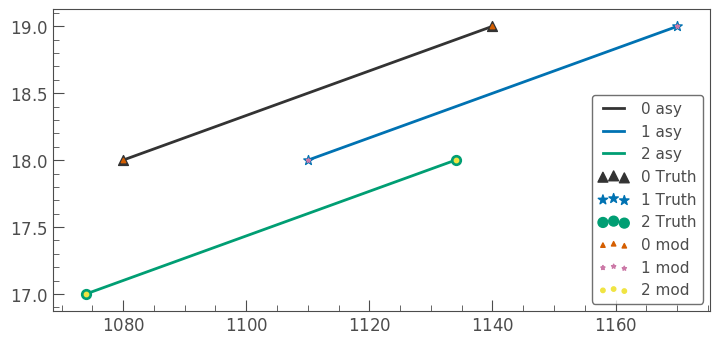

In [35]:
with plt.style.context(lk.MPLSTYLE):
    fig, ax = plt.subplots()
    res = [np.median(trace[label]) for label in ['numax','deltanu','numax','numax','d01','d02']]
    res[2], res[3] = 0., 0.
    resls = [np.median(trace[label],axis=0) for label in ['f0','f1','f2']]
    stdls = [np.std(trace[label],axis=0) for label in ['f0','f1','f2']]
       
    ax.plot(mod.f0(res), n0_, label='0 asy',lw=2, zorder=1)
    ax.plot(mod.f1(res), n1_, label='1 asy',lw=2, zorder=1)
    ax.plot(mod.f2(res), n2_, label='2 asy',lw=2, zorder=1)

    ax.scatter(f0_, n0_, marker='^',label='0 Truth',  s=50, zorder=2)
    ax.scatter(f1_, n1_, marker='*',label='1 Truth',  s=50, zorder=2)
    ax.scatter(f2_, n2_, marker='o',label='2 Truth',  s=50, zorder=2)      
    
    ax.scatter(resls[0], n0_, marker='^',label='0 mod', s=10, zorder=3)
    ax.scatter(resls[1], n1_, marker='*',label='1 mod', s=10, zorder=3)
    ax.scatter(resls[2], n2_, marker='o',label='2 mod', s=10, zorder=3)    
    
    ax.legend(loc='best')    

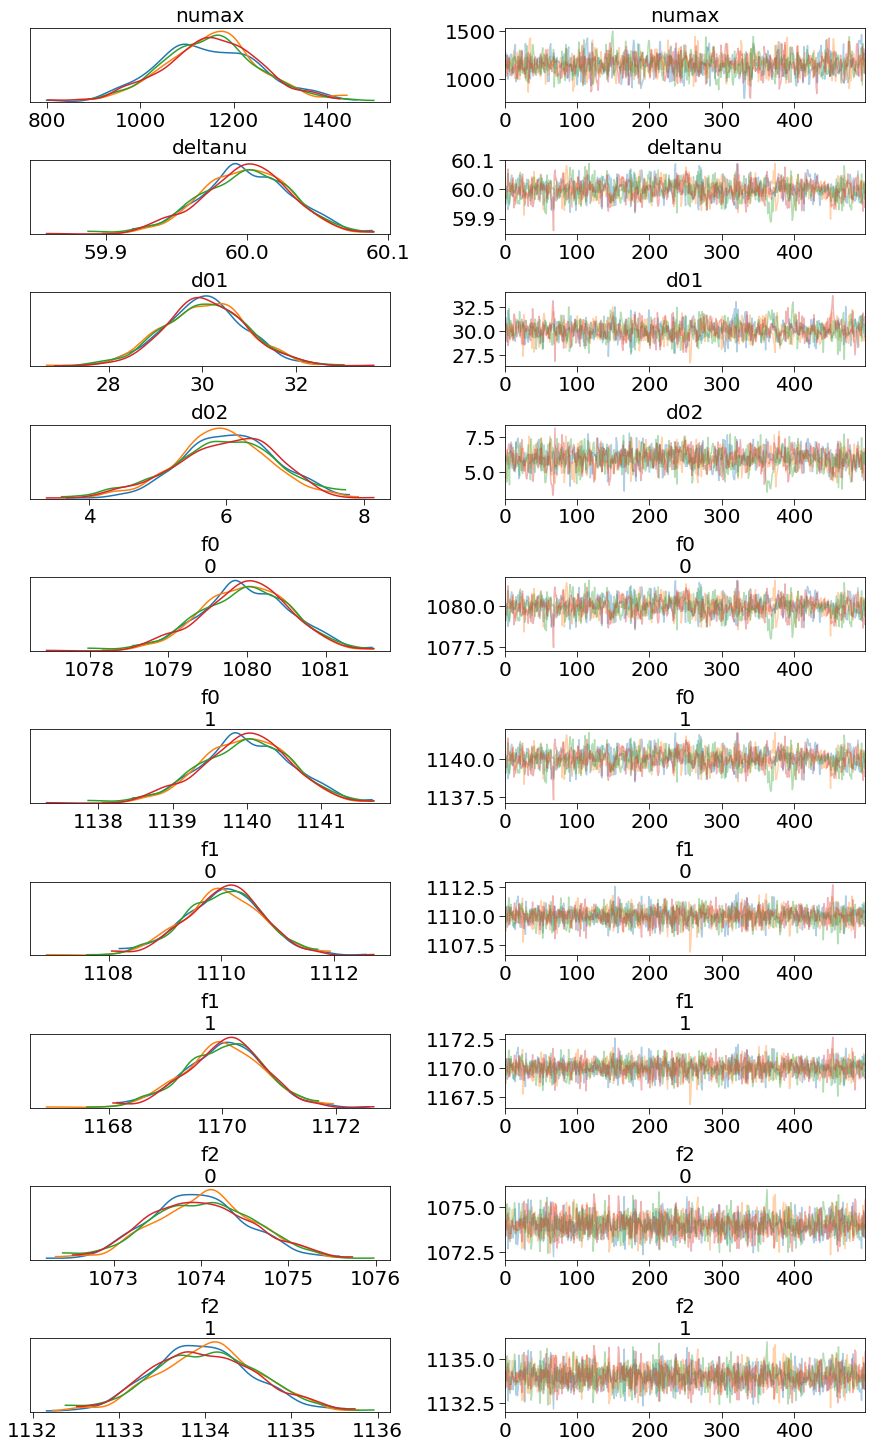

In [37]:
pm.traceplot(trace);

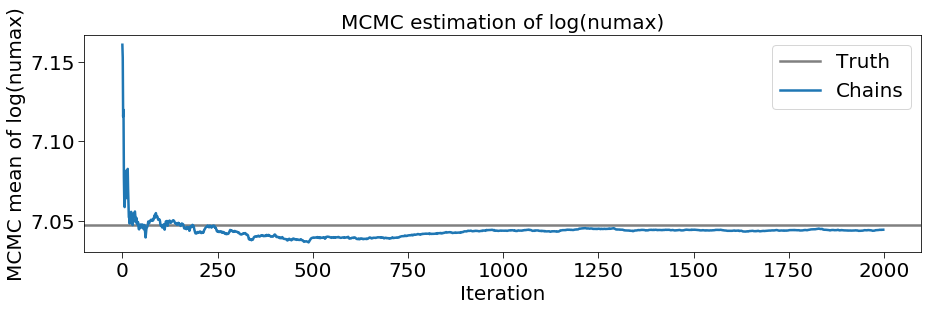

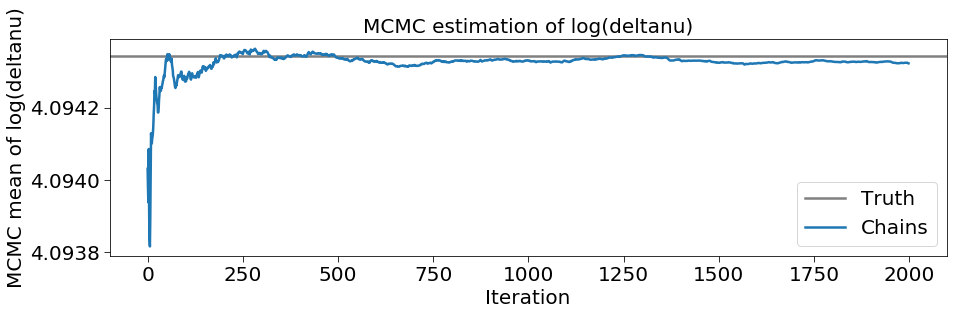

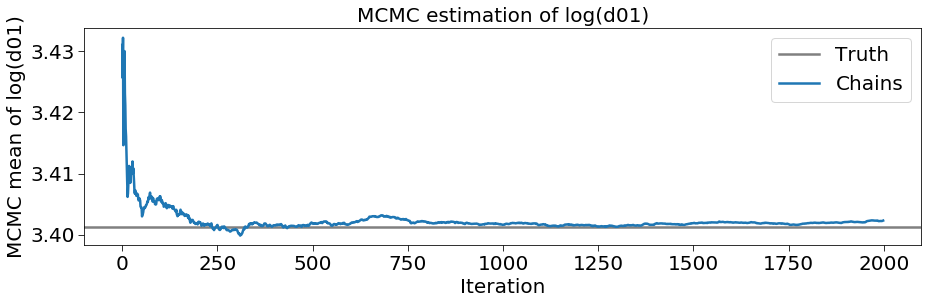

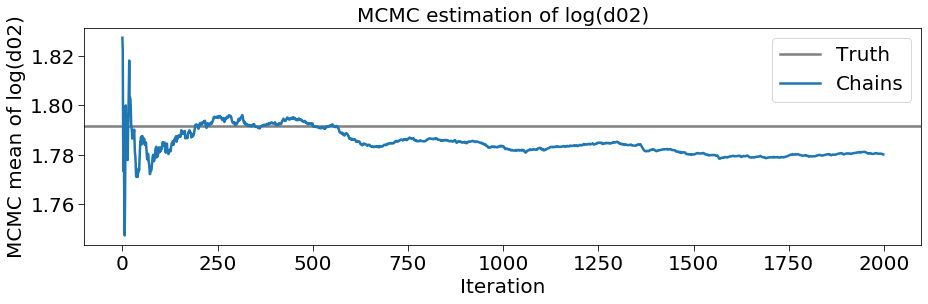

In [36]:
# plot the estimate for the mean of log(τ) cumulating mean
labels=['numax','deltanu','d01','d02']
truths = [numax_, deltanu_, d01_, d02_]
for param, truth in zip(labels, truths):
    logtau = np.log(trace[param])
    mlogtau = [np.mean(logtau[:i]) for i in np.arange(1, len(logtau))]
    plt.figure(figsize=(15, 4))
    plt.axhline(np.log(truth), lw=2.5, color='gray', label='Truth')
    plt.plot(mlogtau, lw=2.5, label='Chains')
    plt.legend(loc='best')
    plt.xlabel('Iteration')
    plt.ylabel('MCMC mean of log({})'.format(param))
    plt.title('MCMC estimation of log({})'.format(param));

# Now lets try and fit this

In [38]:
pm_model = pm.Model()

BNormal = pm.Bound(pm.Normal, lower=0.)

with pm_model:   
    numax   = BNormal('numax',   mu=numax_,   sigma=100.,  testval=numax_)
    deltanu = BNormal('deltanu', mu=deltanu_, sigma=.1,  testval=deltanu_)
#     alpha   = BNormal('alpha',   mu=alpha_,   sigma=0.001,  testval=alpha_)
#     epsilon = BNormal('epsilon', mu=epsilon_, sigma=0.01,   testval=epsilon_)
    d01     = BNormal('d01',     mu=d01_,     sigma=5., testval=d01_)
    d02     = BNormal('d02',     mu=d02_,     sigma=1.,  testval=d02_)
    
    Delta = pm.Normal('Delta', 0, 1)
    
    f0 = pm.Deterministic('f0', mod.f0([numax, deltanu, 0., 0., d01, d02]) + Delta)
    f1 = pm.Deterministic('f1', mod.f1([numax, deltanu, 0., 0., d01, d02]) + Delta)
    f2 = pm.Deterministic('f2', mod.f2([numax, deltanu, 0., 0., d01, d02]) + Delta)
        
    g0 = pm.HalfNormal('g0', sigma=2.0, testval=init_m[3], shape=len(init_m[3]))
    g1 = pm.HalfNormal('g1', sigma=2.0, testval=init_m[4], shape=len(init_m[4]))
    g2 = pm.HalfNormal('g2', sigma=2.0, testval=init_m[5], shape=len(init_m[5]))

    a0 = pm.HalfNormal('a0', sigma=20., testval=init_m[6], shape=len(init_m[6]))
    a1 = pm.HalfNormal('a1', sigma=20., testval=init_m[7], shape=len(init_m[7]))
    a2 = pm.HalfNormal('a2', sigma=20., testval=init_m[8], shape=len(init_m[8]))
    
    h0 = pm.Deterministic('h0', 2*a0**2/np.pi/g0)
    h1 = pm.Deterministic('h1', 2*a1**2/np.pi/g1)
    h2 = pm.Deterministic('h2', 2*a2**2/np.pi/g2)
    
    xsplit = pm.HalfNormal('xsplit', sigma=2.0, testval=init_m[9] * np.sin(init_m[10]))
    cosi = pm.Uniform('cosi', 0., 1., testval=np.cos(init_m[10]))
    
    i = pm.Deterministic('i', tt.arccos(cosi))
    split = pm.Deterministic('split', xsplit/tt.sin(i))
    
    b = BNormal('b', mu=1., sigma=.1, testval=1.)
    
    fit = mod.model([f0, f1, f2, g0, g1, g2, h0, h1, h2, split, i, b])
    
    like = pm.Gamma('like', alpha=1., beta=1./fit, observed=p)

In [39]:
with pm_model:
    trace = pm.sample(chains=4)#, draws=100, tune=400)

INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [b, cosi, xsplit, a2, a1, a0, g2, g1, g0, Delta, d02, d01, deltanu, numax]
Sampling 4 chains: 100%|██████████| 4000/4000 [16:46<00:00,  1.10s/draws] 
ERROR:pymc3:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


In [40]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Delta,-0.357749,9.092997,0.905607,-1.146086e+01,15.072655,2.015809,12.436472
numax,1151.313759,103.827359,1.975002,9.590916e+02,1368.590416,2606.305511,0.999830
deltanu,59.950255,1.656622,0.165586,5.795390e+01,62.617676,2.003896,34.037223
d01,42.247464,22.372060,2.230898,1.553435e+01,79.743220,2.014180,13.613714
d02,9.684805,4.583250,0.454267,5.144747e+00,17.820327,2.034018,8.302043
f0__0,1078.746842,38.859165,3.885470,1.032928e+03,1140.203443,2.002707,57.545718
f0__1,1138.697097,40.515127,4.051048,1.090916e+03,1202.774474,2.002709,57.487625
f1__0,1120.994306,56.675378,5.665352,1.077453e+03,1219.420655,2.003394,39.874401
f1__1,1180.944561,58.260543,5.823926,1.135561e+03,1281.965431,2.003313,41.080101
f2__0,1069.062037,42.678641,4.267809,1.016172e+03,1134.418493,2.002440,78.030012


## Lets investigate the divergences

From the PyMC3 docs: https://docs.pymc.io/notebooks/Diagnosing_biased_Inference_with_Divergences.html

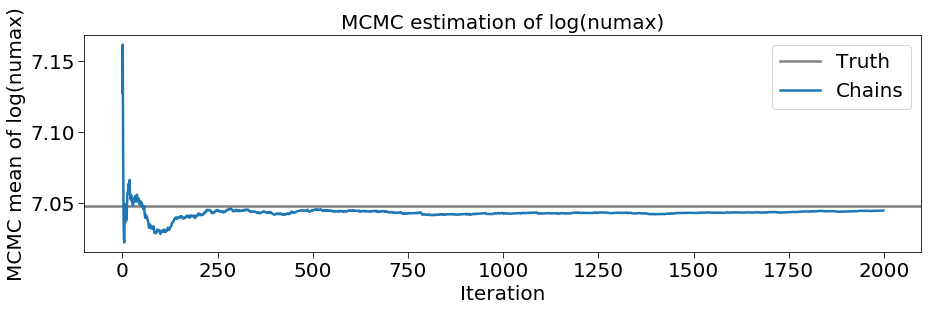

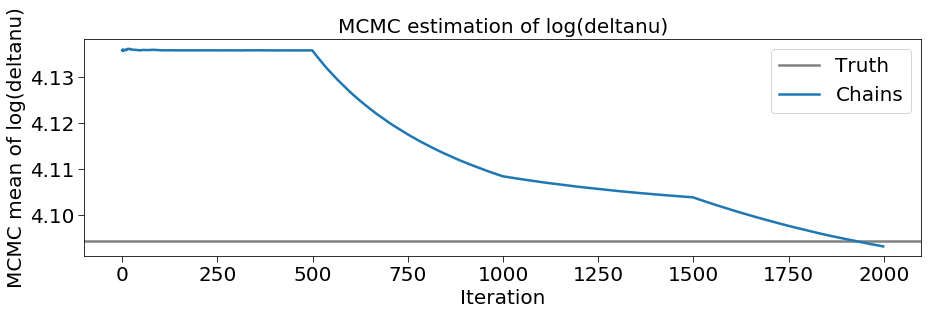

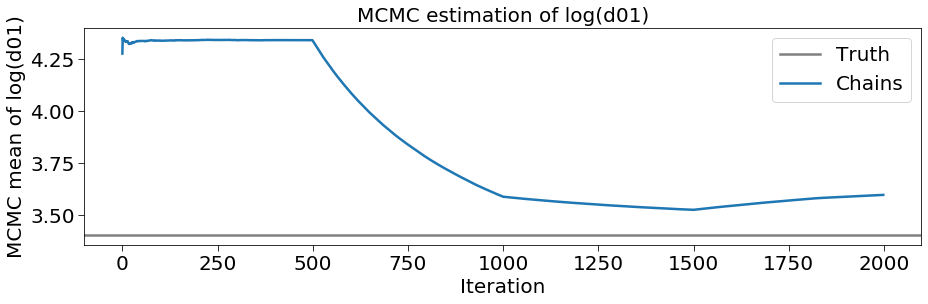

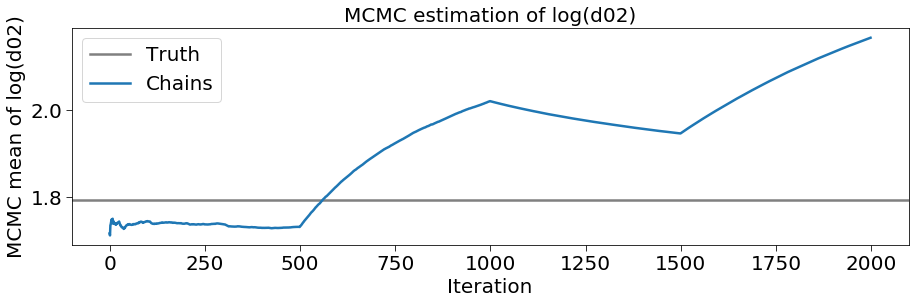

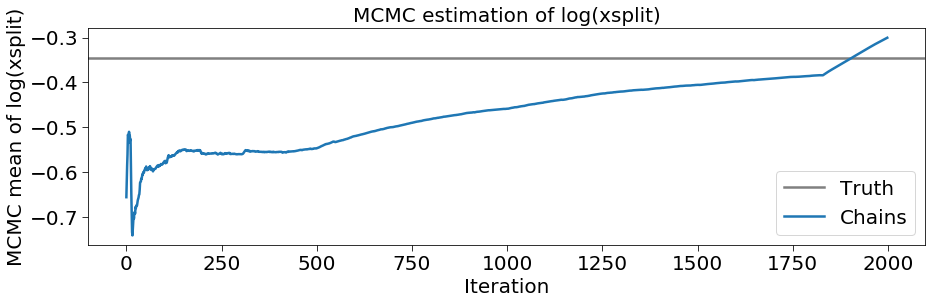

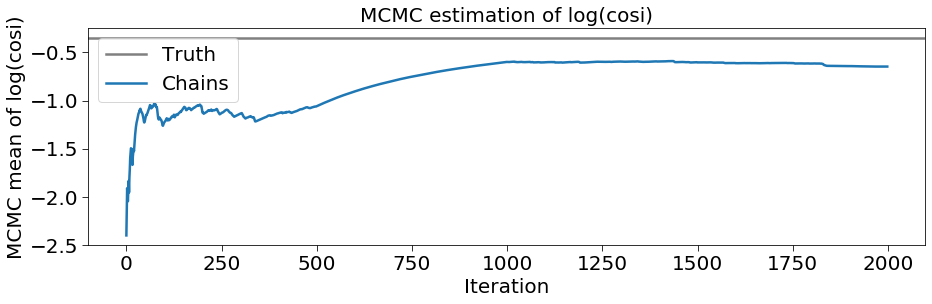

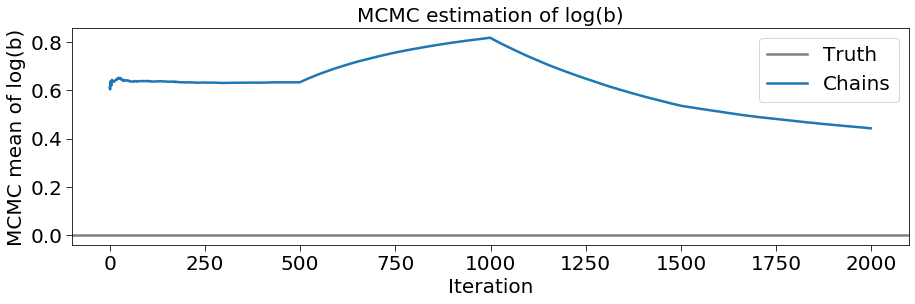

In [41]:
# plot the estimate for the mean of log(τ) cumulating mean
labels=['numax','deltanu','d01','d02', 'xsplit','cosi','b']
truths = [numax_, deltanu_, d01_, d02_,
          init_m[9]*np.sin(init_m[10]), np.cos(init_m[10]), init_m[11]]
for param, truth in zip(labels, truths):
    logtau = np.log(trace[param])
    mlogtau = [np.mean(logtau[:i]) for i in np.arange(1, len(logtau))]
    plt.figure(figsize=(15, 4))
    plt.axhline(np.log(truth), lw=2.5, color='gray', label='Truth')
    plt.plot(mlogtau, lw=2.5, label='Chains')
    plt.legend(loc='best')
    plt.xlabel('Iteration')
    plt.ylabel('MCMC mean of log({})'.format(param))
    plt.title('MCMC estimation of log({})'.format(param));

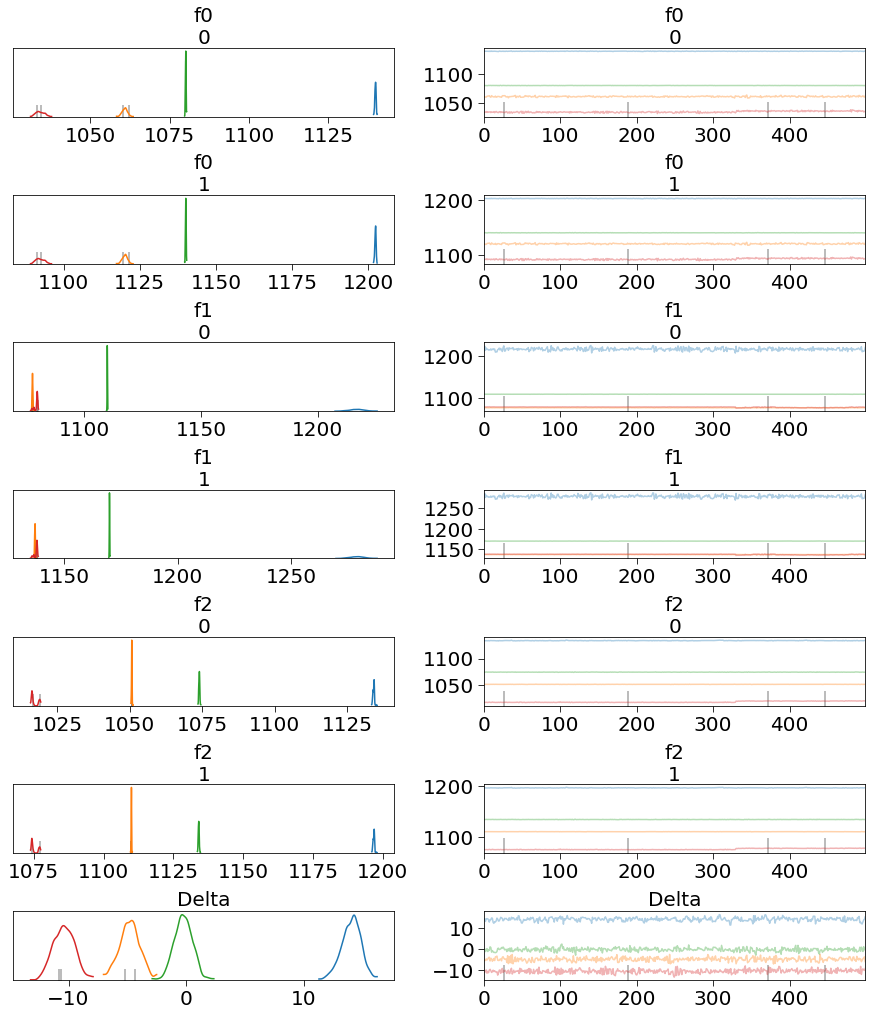

In [42]:
pm.traceplot(trace, var_names=['f0','f1','f2','Delta']);

# Now lets plot some diagnostics...

In [ ]:
labels=['xsplit','cosi','split','i','b',
'numax','deltanu','alpha','epsilon','d01','d02']
verbose = [r'$\delta\nu_s^*$',r'$\cos(i)$',r'$\delta\nu_{\rm s}$', r'$i$','b',
          r'$\nu_{\rm max}$',r'$\Delta\nu$',r'$\alpha$',r'$\epsilon$',r'$\delta\nu_{01}$',r'$\delta\nu_{02}$']

In [ ]:
truths = [init_m[9] * np.sin(init_m[10]), np.cos(init_m[10]), init_m[9], init_m[10], 1.,
          numax_, deltanu_, alpha_, epsilon_, d01_, d02_]
chain = np.array([trace[label] for label in labels])

corner.corner(chain.T, labels=verbose, quantiles=[0.16, 0.5, 0.84]
              ,truths=truths, show_titles=True)
plt.show()

In [ ]:
with plt.style.context(lk.MPLSTYLE):
    fig, ax = plt.subplots(2, figsize=(8.75, 8), sharex=True )
    ax[0].plot(f, p)
    labels=['f0','f1','f2','g0','g1','g2','h0','h1','h2','split','i', 'b']
    res = np.array([np.median(trace[label],axis=0) for label in labels])    
    ax[0].plot(f, mod.model(res, theano=False), lw=2)

    res = [np.median(trace[label]) for label in ['numax','deltanu','alpha','epsilon','d01','d02']]
    resls = [np.median(trace[label],axis=0) for label in ['f0','f1','f2']]
    stdls = [np.std(trace[label],axis=0) for label in ['f0','f1','f2']]
    
    ax[1].plot(mod.f0(res), n0_, label='0 asy',lw=2, zorder=1)
    ax[1].plot(mod.f1(res), n1_, label='1 asy',lw=2, zorder=1)
    ax[1].plot(mod.f2(res), n2_, label='2 asy',lw=2, zorder=1)
    
    ax[1].plot(mod.f0(a), n0_, label='0 asy truth',lw=1, zorder=2)
    ax[1].plot(mod.f1(a), n1_, label='1 asy truth',lw=1, zorder=2)
    ax[1].plot(mod.f2(a), n2_, label='2 asy truth',lw=1, zorder=2)    

    ax[1].scatter(f0_, n0_, marker='^',label='0 Truth',  s=50, zorder=3)
    ax[1].scatter(f1_, n1_, marker='*',label='1 Truth',  s=50, zorder=3)
    ax[1].scatter(f2_, n2_, marker='o',label='2 Truth',  s=50, zorder=3)  
    
    ax[1].scatter(resls[0], n0_, marker='^',label='0 mod', s=10, zorder=4)
    ax[1].scatter(resls[1], n1_, marker='*',label='1 mod', s=10, zorder=4)
    ax[1].scatter(resls[2], n2_, marker='o',label='2 mod', s=10, zorder=4)      
    
    ax[1].legend(loc='best')       

In [ ]:
with plt.style.context(lk.MPLSTYLE):
    fig, ax = plt.subplots()
    res = [np.median(trace[label]) for label in ['numax','deltanu','alpha','epsilon','d01','d02']]
    resls = [np.median(trace[label],axis=0) for label in ['f0','f1','f2']]
    stdls = [np.std(trace[label],axis=0) for label in ['f0','f1','f2']]
    
    ax.plot(mod.f0(res)%res[1], n0_, label='0 asy',lw=2, zorder=1)
    ax.plot(mod.f1(res)%res[1], n1_, label='1 asy',lw=2, zorder=1)
    ax.plot(mod.f2(res)%res[1], n2_, label='2 asy',lw=2, zorder=1)

    ax.scatter(f0_%res[1], n0_, marker='^',label='0 Truth',  s=50, zorder=2)
    ax.scatter(f1_%res[1], n1_, marker='*',label='1 Truth',  s=50, zorder=2)
    ax.scatter(f2_%res[1], n2_, marker='o',label='2 Truth',  s=50, zorder=2)      
    
    ax.scatter(resls[0]%res[1], n0_, marker='^',label='0 mod', s=10, zorder=3)
    ax.scatter(resls[1]%res[1], n1_, marker='*',label='1 mod', s=10, zorder=3)
    ax.scatter(resls[2]%res[1], n2_, marker='o',label='2 mod', s=10, zorder=3)    
    
    ax.legend(loc='best') 

In [ ]:
for idx in range(len(trace['h0'].T)):
    chain = np.array([trace['a0'].T[idx], trace['h0'].T[idx], trace['g0'].T[idx], trace['f0'].T[idx]])
    corner.corner(chain.T, labels=['A','H','g','f'],
                  quantiles=[0.16, 0.5, 0.84],show_titles=True)
    plt.show()

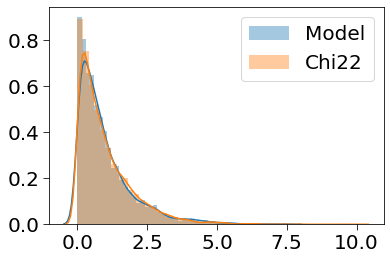

In [99]:
labels=['f0','f1','f2','g0','g1','g2','h0','h1','h2','split','i', 'b']
res = np.array([np.median(trace[label],axis=0) for label in labels])  
residual = p/mod.model(res, theano=False)
sns.distplot(residual, label='Model')
sns.distplot(np.random.chisquare(2, size=10000)/2, label=r'Chi22')
plt.legend()